# Run Your Own Scenarios

This notebook shows how the code can be used to run your own scenarios.

Developed by Siobhan Powell, 2021.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import boto3
import numpy as np
import pickle
import time
from speech_classes import SPEECh
from speech_classes import SPEEChGeneralConfiguration
from speech_classes import LoadProfile
from speech_classes import Plotting
from speech_classes import DataSetConfigurations

In [2]:
def plot(load_segments_array, load_segments_dict, data, save_str):
    
    x = (1/60)*np.arange(0, 1440)
    mark = np.zeros(np.shape(x))
    scaling = 1 / 1000
    unit = 'MW'
    if np.max(scaling * np.sum(load_segments_array, axis=1)) > 1000:
        scaling = (1 / 1000) * (1 / 1000)
        unit = 'GW'
    plt.figure(figsize=(8, 5))
    for key, val in load_segments_dict.items():
        plt.plot(x, scaling * (mark + val), color=data.colours[key])
        plt.fill_between(x, scaling * mark, scaling * (mark + val), label=key, color=data.colours[key])
        mark += val
    plt.plot(x, scaling * mark, 'k')
    plt.legend(fontsize=12, loc='upper left')
    plt.xlim([0, np.max(x)])
    plt.ylim([0, 1.1 * np.max(scaling * mark)])
    plt.ylabel(unit, fontsize=14)
    plt.xlabel('Hour', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig(save_str, bbox_inches='tight')
    plt.show()
    
    return

In [4]:
data = DataSetConfigurations(data_set='CP')
speech = SPEECh(data=data, outside_california=False, bypass_adoption=True)

We cannot post the data on income, housing, and mileage - To access this data for the US please contact simplyanalytics.com, or use other sources local to your area. 

For your area you can: 
- Determine the distribution of access, battery capacity, and energy. This may depend on many assumptions, including but not limited to the methodology we used in the paper
- Input them in the following code

We have provided the key files describing each driver group, $g$, as well as the key link `pg_abe_workprice.csv` or $P(G|A, B, E)$ based on those groups. 

In [5]:
# Access example

# first row: 65% of drivers have no workplace charging
# second row: 25% of drivers have paid workplace charging
# third row: 10% of drivers have free workplace charging
# first column: 30% of drivers have no home charging 
# second column: no drivers have home l1 charging (note, always make this 0 for the current model)
# third column: 60% of drivers have home SFH L2 charging
# fourth column: 10% of drivers have home MUD charging

a= {'work_0_home_0':0.195, 'work_0_home_l1':0, 'work_0_home_l2':0.39, 'work_0_home_mud':0.065, 
    'work_paid_home_0':0.075, 'work_paid_home_l1':0, 'work_paid_home_l2':0.15, 'work_paid_home_mud':0.025,
    'work_free_home_0':0.03, 'work_free_home_l1':0, 'work_free_home_l2':0.06, 'work_free_home_mud':0.01}

In [6]:
sum(a.values()) # make sure these sum to 1!

1.0

In [7]:
# Battery capacity example
b = {'largebattery_0':0.2, 'largebattery_1':0.8} # 80% of drivers have battery capacities over 50 kWh

In [8]:
# Energy example
e = {'energy_0_600': 0.1, 'energy_600_1000':0.1, 'energy_1000_1600':0.2,
     'energy_1600_2000':0.15, 'energy_2000_3000':0.2, 'energy_3000_4000':0.2, 'energy_4000_6000':0.05}

In [9]:
speech.p_abe_separate(a=a, b=b, e=e) # input those models of access, battery capacity, and energy distributions
speech.pg_abe() # calculate distribution of driver groups, p(g), based on that

In [10]:
config = SPEEChGeneralConfiguration(speech, remove_timers=False, utility_region='PGE') # configure model
config.num_evs(1000) # 1000 drivers as test case
config.groups() # sets up driver groups

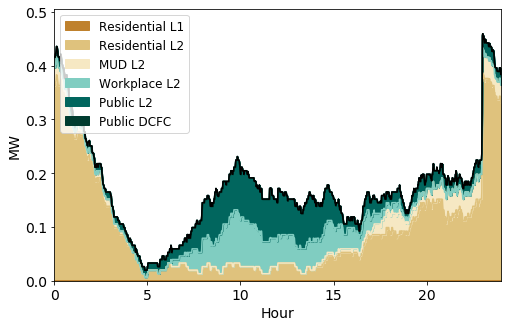

In [11]:
plots = Plotting(speech, config) # run model and plot
plots.total(weekday='weekday') # weekday 

In [12]:
# outputs: 
plots.config.total_load_dict

{'Residential L1': array([0., 0., 0., ..., 0., 0., 0.]),
 'Residential L2': array([363.        , 363.        , 363.        , ..., 343.2       ,
        342.85958854, 330.9124805 ]),
 'MUD L2': array([33., 33., 33., ..., 33., 33., 33.]),
 'Workplace L2': array([0., 0., 0., ..., 0., 0., 0.]),
 'Public L2': array([19.8, 19.8, 19.8, ..., 19.8, 19.8, 19.8]),
 'Public DCFC': array([0., 0., 0., ..., 0., 0., 0.])}

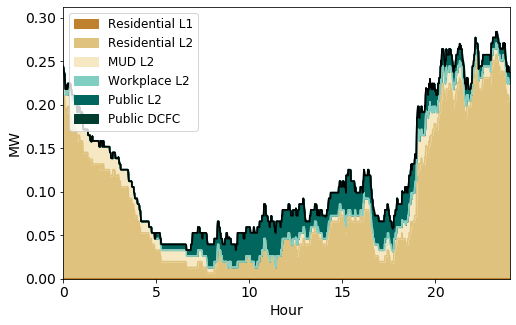

In [13]:
plots = Plotting(speech, config)
plots.total(weekday='weekend') # weekend

### Change the assumptions: another example

In [15]:
# Access example - change such that all workplace charging is free

a= {'work_0_home_0':0.195, 'work_0_home_l1':0, 'work_0_home_l2':0.39, 'work_0_home_mud':0.065, 
    'work_paid_home_0':0, 'work_paid_home_l1':0, 'work_paid_home_l2':0, 'work_paid_home_mud':0,
    'work_free_home_0':0.105, 'work_free_home_l1':0, 'work_free_home_l2':0.21, 'work_free_home_mud':0.035}

In [16]:
sum(a.values())

0.9999999999999999

In [17]:
# Battery example - give everyone large battery vehicles
b = {'largebattery_0':0, 'largebattery_1':1.0}

In [19]:
data = DataSetConfigurations(data_set='CP')
speech = SPEECh(data=data, outside_california=False, bypass_adoption=True)
speech.p_abe_separate(a=a, b=b, e=e) # input those models of access, battery capacity, and energy distributions
speech.pg_abe() # calculate distribution of driver groups, p(g), based on that

In [20]:
config = SPEEChGeneralConfiguration(speech, remove_timers=False, utility_region='PGE') # configure model
config.num_evs(1000) # 1000 drivers as test case
config.groups() # sets up driver groups

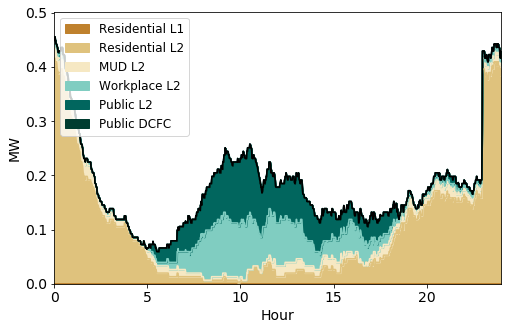

In [21]:
plots = Plotting(speech, config) # run model and plot
plots.total(weekday='weekday') # weekday 

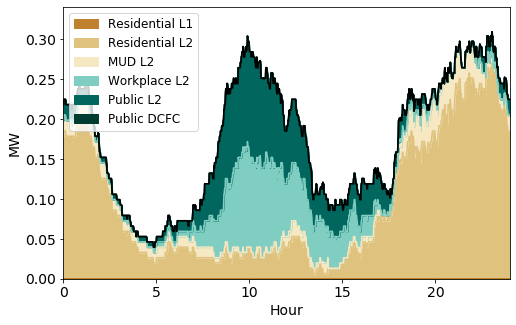

In [22]:
# remove timers
config = SPEEChGeneralConfiguration(speech, remove_timers=True, utility_region='PGE') # configure model
config.num_evs(1000) # 1000 drivers as test case
config.groups() # sets up driver groups
plots = Plotting(speech, config) # run model and plot
plots.total(weekday='weekday') # weekday 